<br><br>

# Exercício: Sistemas de Recomendação

<br>

__Introdução: o objetivo deste exercício é discutirmos uma metodologia de avaliação de filtros colaborativos.__

<br>

Para isso, utilize a função getData() para carregar os dados: 

    - teremos avaliações que 367 usuários fizeram a respeito de 80 filmes. As notas variam entre 1, 2, 3, 4, e 5. 
    
    - os valores NaN representam filmes que ainda não foram avaliados pelos usuários.

Como __modelo__ para as recomendações, usaremos a __fatoração matricial.__ Use a classe MatrixFactorization() construída ao longo do módulo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getData():
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('u.data', sep='\t', names=r_cols,
                          encoding='latin-1')
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
    movies = pd.read_csv('u.item', sep='|', names=m_cols, usecols=range(5),
                         encoding='latin-1')
    movie_ratings = pd.merge(movies, ratings)
    temp = movie_ratings[['movie_id', 'user_id', 'rating']].copy()
    temp = temp.pivot_table(columns='movie_id', index='user_id', values='rating').copy()
    temp.index = ['User_'+str(int(i)) for i in temp.index]
    temp.columns = ['Filme_'+str(int(i)) for i in temp.columns]
    qtd_cols = 80
    R = temp.iloc[:, :qtd_cols]
    l=[]
    for i in range(1, R.shape[0]+1):
        if R.iloc[i-1, ].isnull().sum() >= (qtd_cols - 10):
            l.append(i)
    R = R.drop(["User_"+str(r) for r in l])
    R.index = ['User_'+str(int(i)) for i in range(R.shape[0])]
    return R

In [3]:
import time

class MatrixFactorization():
    
    def __init__(self, dataframe, K, steps, alpha, beta):
        self.df = dataframe
        self.K = K
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        
    def fit(self):
        t0 = time.time()
        
        R = self.df.values
        N, M = R.shape
        
        #inicio aleatorio
        P = np.random.rand(N,self.K)
        Q = np.random.rand(self.K,M)
        
        lista_erro_step = []
        
        #loop
        for step in range(self.steps):
            
            mse_total_step = 0
            #varrendo todas as entradas da matriz R
            for i in range(len(R)):
                for j in range(len(R[i])):
                    #validando se o valor associado está preenchido
                    if R[i][j] > 0:

                        #calculando o erro:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        mse_total_step += (eij)**2
                        #alterando os valores
                        for k in range(self.K):
                            P[i][k] = P[i][k] + self.alpha * ( 2 * eij * Q[k][j] - self.beta * P[i][k])
                            Q[k][j] = Q[k][j] + self.alpha * ( 2 * eij * P[i][k] - self.beta * Q[k][j])
                            
            lista_erro_step.append(mse_total_step)
            
        self.P = P
        self.Q = Q
        self.lista_erro_step = lista_erro_step
        t1 = time.time()
        #print("Fatoração concluída. Tempo aproximado:", int((t1-t0)/60)+1, 'minuto(s).')
        
    def predict(self):
        return self.P.dot(self.Q)
    
    def print_MSE_steps(self):
        plt.figure(figsize=[15,6])
        plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
        plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
        plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')
        plt.plot(range(1, 1+self.steps), self.lista_erro_step, c = 'blue', lw = 2)
        plt.grid()
        plt.show()

In [4]:
def train_test_split(ratings, qtd):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

<br>

### Exercício:

Carregue o conjunto de dados a partir da função getData() e utilize o modelo de fatoração matricial.

Faça uma divisão dos dados em treino/validação/teste de acordo com a metodologia acima discutida (Utilize qtd = 2, ou seja, 2 interações por usuário serão retiradas na divisão dos dados). 

Testando vários conjuntos de parâmetros - isto é, um análogo ao Grid Search de modelos - encontre a melhor fatoração matricial para realizarmos recomendações neste dataset.

Obs.: esse grid search acima pode ser feito manualmente, implementado num loop.

In [5]:
R = getData()
print(R.shape)
R

(367, 80)


,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_2,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
User_3,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,NaN,NaN,NaN,5.0,3.0,4.0,4.0
User_4,4.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_363,2.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_364,4.0,NaN,4.0,NaN,NaN,5.0,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_365,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# extração da matriz de interação no formato de array, preenchendo os valores faltantes com zeros.

matriz_inter = R.fillna(0).values

In [7]:
# divisão do dataset em treino e teste através do método de simulação, retirando dois valores de interações já existentes
# no dataset original

Rtrain, Rtest = train_test_split(ratings = matriz_inter, qtd = 2)

In [8]:
# nova divisão do dataset de treino com a mesma metodologia, agora para criar o conjunto de validação

Rtrain, Rval = train_test_split (ratings = Rtrain, qtd = 2)

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
# junção dos três conjuntos corresponde à matriz original

Rtrain + Rval + Rtest == matriz_inter

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [11]:
# importação da métrica que será usada para avaliar os modelos

from sklearn.metrics import mean_squared_error

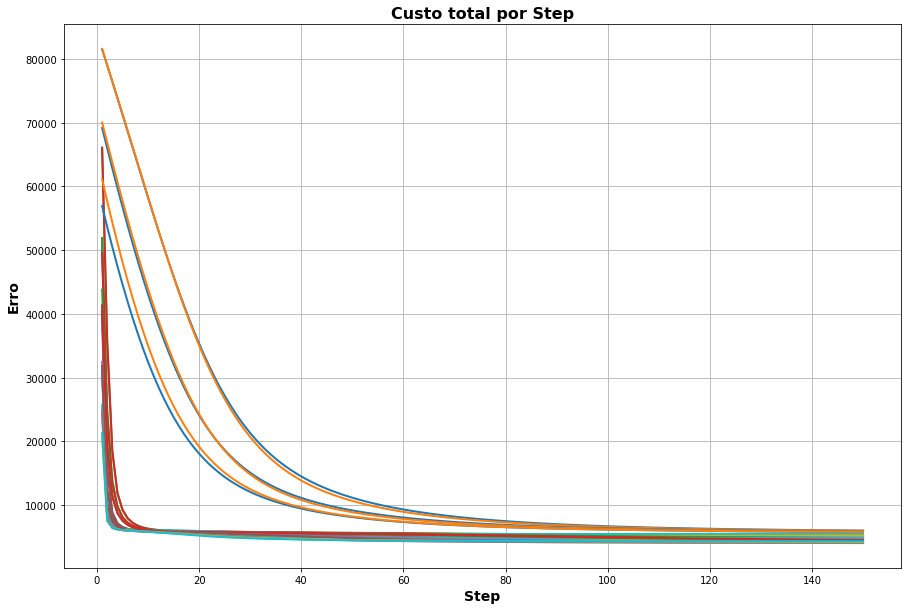

In [12]:
# este bloco executa um grid search manual, iterando sobre os parâmetros do modelo informados num dicionário

plt.figure(figsize=[15,10])
plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')

# definição do dicionário com os parâmetros a serem testados
grid_params = {'K':[2,3,4],'step':[150],'alpha':np.linspace(0.0001,0.005,5).tolist(),'beta':[0.01,0.0001]}

grid_results = {}

# armazenamento dos índices das entradas do dataset de validação com valores preenchidos, para utilização no cálculo do RMSE
id_val = Rval.nonzero()

i=0

for k in grid_params['K']:
    for s in grid_params['step']:
        for a in grid_params['alpha']:
            for b in grid_params['beta']:
                fat = MatrixFactorization(dataframe = pd.DataFrame(Rtrain, columns = R.columns, index = R.index),
                                               K=k, steps = s, alpha=a, beta=b)
                fat.fit()
                
                # São plotadas as curvas de cada modelo (erro em função de step)
                # para verificar a convergência dos erros para valores limite.
                plt.plot(range(1, 1+fat.steps), fat.lista_erro_step, lw = 2)
                
                # é calculado o RMSE, comparando os somente os valores não nulos do conjunto de validação com seus
                # equivalentes na matriz predita pelo modelo
                rmse_val = mean_squared_error(y_true = Rval[id_val], y_pred = fat.predict()[id_val], squared=False)
                
                # os parâmetros do modelo e o RMSE são armazenados em outro dicionário
                grid_results[i]=[k,s,a,b,rmse_val]
                i+=1

plt.grid()
plt.show()

In [13]:
# criamos um dataframe com os dados de cada modelo e a respectiva métrica, ordenados decrescentemente conforme esta.

fat_results = pd.DataFrame.from_dict(grid_results, orient = 'index',
                                     columns=list(grid_params.keys())+['rmse']).sort_values(by='rmse')
fat_results

,K,step,alpha,beta,rmse
4,2,150,0.002550,0.0100,0.970982
6,2,150,0.003775,0.0100,0.976051
8,2,150,0.005000,0.0100,0.976896
5,2,150,0.002550,0.0001,0.979286
2,2,150,0.001325,0.0100,0.981796
20,4,150,0.000100,0.0100,0.985595
9,2,150,0.005000,0.0001,0.986837
3,2,150,0.001325,0.0001,0.987329
21,4,150,0.000100,0.0001,0.987829
11,3,150,0.000100,0.0001,0.989918


In [14]:
# coletamos os parâmetros do modelo com melhor desempenho

best_params = fat_results.iloc[0,:].values
best_params

array([2.00000000e+00, 1.50000000e+02, 2.55000000e-03, 1.00000000e-02,
       9.70982228e-01])

In [15]:
# instanciamos a matriz de fatoração com os parâmetros obtidos do modelo com melhor desempenho

fat = MatrixFactorization(dataframe = pd.DataFrame(Rtrain, columns = R.columns, index = R.index),
                                    K=best_params[0].astype(int), steps = best_params[1].astype(int),
                                    alpha=best_params[2], beta=best_params[3])

In [16]:
fat.fit()

In [17]:
# como feito anteriormente com a validação, coletamos os índices das posições não nulas do array de teste para
# comparar os valores com os da matriz de predição
id_test = Rtest.nonzero()

rmse_teste = mean_squared_error(y_true = Rtest[id_test], y_pred = fat.predict()[id_test], squared=False)
print ("RMSE validação: "+str(round(fat_results.iloc[0,4],4)))
print ("RMSE treino: "+str(round(rmse_teste,4)))

RMSE validação: 0.971
RMSE treino: 0.9716


As métricas obtidas em validação e teste são próximas, o que sugere que o modelo é estável para as predições.
(em testes preliminares, com valores mais baixos de 'steps' obtivemos melhores métricas de validação, mas em teste foram discrepantes (mais altas) o que provavelmente indica algum tipo de overfitting.</br>
Como os modelos escolhidos todos convergiram para valores limite de erro durante o treino, supõe-se que são confiáveis sob o ponto de vista da generalização.</br>